In [26]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', as_frame=False)

In [27]:
X, y = mnist.data, mnist.target
X

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [28]:
print("X shape: ",X.shape)
print("y shape: ",y.shape)

X shape:  (70000, 784)
y shape:  (70000,)


There are 70,000 images, and each image has 784 features. This is because
each image is 28 × 28 pixels, and each feature simply represents one pixel’s
intensity, from 0 (white) to 255 (black). Let’s take a peek at one digit from
the dataset.

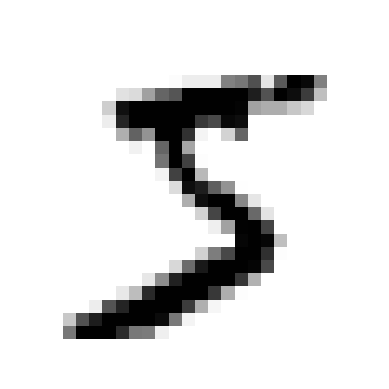

In [29]:
import matplotlib.pyplot as plt

def plot_digit(image_data):
    image = image_data.reshape(28, 28)
    plt.imshow(image, cmap="binary")
    plt.axis("off")

some_digit = X[0]
plot_digit(some_digit)
# save_fig("some_digit_plot")  # extra code
plt.show()

# The Data
The MNIST dataset returned by
fetch_openml() is actually already split into a training set (the first
60,000 images) and a test set (the last 10,000 images). The training set is already shuffled for us

In [30]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# Multiclass Classification

Scikit-Learn detects when you try to use a binary classification algorithm
for a multiclass classification task, and it automatically runs OvR or OvO,
depending on the algorithm. Let’s try this with a Support Vector Machine
classifier using the sklearn.svm.SVC class (see Chapter 5). We’ll only
train on the first 2,000 images or else it will take a very long time:

In [31]:
from sklearn.svm import SVC

svm_clf = SVC(random_state=42)
svm_clf.fit(X_train[:2000], y_train[:2000])  # y_train, not y_train_5
# svm uses ovo by default

SVC(random_state=42)

In [32]:
svm_clf.predict([some_digit])

array(['5'], dtype=object)

This code actually made 45 predictions—one per pair of
classes—and it selected the class that won the most duels. If you call the
decision_function() method, you will see that it returns 10 scores
per instance: one per class. Each class gets a score equal to the number of
won duels plus or minus a small tweak (max ±0.33) to break ties, based on
the classifier scores:

In [33]:
some_digit_score = svm_clf.decision_function([some_digit])
some_digit_score.round(2)

array([[ 3.79,  0.73,  6.06,  8.3 , -0.29,  9.3 ,  1.75,  2.77,  7.21,
         4.82]])

If you want `decision_function()` to return all 45 scores, you can set the `decision_function_shape` hyperparameter to `"ovo"`. The default value is `"ovr"`, but don't let this confuse you: `SVC` always uses OvO for training. This hyperparameter only affects whether or not the 45 scores get aggregated or not:

In [34]:
svm_clf.decision_function_shape = 'ovo'
some_digit_score_ovo = svm_clf.decision_function([some_digit])
some_digit_score_ovo.round(2)

array([[ 0.11, -0.21, -0.97,  0.51, -1.01,  0.19,  0.09, -0.31, -0.04,
        -0.45, -1.28,  0.25, -1.01, -0.13, -0.32, -0.9 , -0.36, -0.93,
         0.79, -1.  ,  0.45,  0.24, -0.24,  0.25,  1.54, -0.77,  1.11,
         1.13,  1.04,  1.2 , -1.42, -0.53, -0.45, -0.99, -0.95,  1.21,
         1.  ,  1.  ,  1.08, -0.02, -0.67, -0.14, -0.3 , -0.13,  0.25]])

In [35]:
class_id = some_digit_score.argmax()
class_id

5

In [36]:
svm_clf.classes_

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'], dtype=object)

In [37]:
svm_clf.classes_[class_id]

'5'

If you want to force Scikit-Learn to use one-versus-one or one-versus-the-
rest, you can use the OneVsOneClassifier or
OneVsRestClassifier classes. Simply create an instance and pass a
classifier to its constructor (it does not even have to be a binary classifier).
For example, this code creates a multiclass classifier using the OvR
strategy, based on an SVC:

In [38]:
from sklearn.multiclass import OneVsRestClassifier
ovr_clf = OneVsRestClassifier(estimator=SVC(random_state=42))
ovr_clf.fit(X_train[:2000], y_train[:2000])

OneVsRestClassifier(estimator=SVC(random_state=42))

In [39]:
ovr_clf.predict([some_digit])

array(['5'], dtype='<U1')

In [40]:
len(ovr_clf.estimators_)

10

Training an SGDClassifier on a multiclass dataset and using it to make
predictions is just as easy:

In [41]:
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array(['3'], dtype='<U1')

Oops, that’s incorrect. Prediction errors do happen! This time Scikit-Learn
used the OvR strategy under the hood: since there are 10 classes, it trained
10 binary classifiers. The decision_function() method now returns
one value per class. Let’s look at the score that the SGD classifier assigned
to each class:

In [42]:
sgd_clf.decision_function([some_digit]).round()

array([[-31893., -34420.,  -9531.,   1824., -22320.,  -1386., -26189.,
        -16148.,  -4604., -12051.]])

In [43]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train, scoring='accuracy', cv=3)

array([0.87365, 0.85835, 0.8689 ])

It gets over 85.8% on all test folds. If you used a random classifier, you
would get 10% accuracy, so this is not such a bad score,

but you can still do much better. Simply scaling the inputs (as discussed in Chapter 2) increases accuracy above 89.1%

In [44]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype('float64'))

In [45]:
cross_val_score(sgd_clf, X_train_scaled, y_train, scoring='accuracy', cv=3)

array([0.8983, 0.891 , 0.9018])

# Error Analysis

In [46]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import ConfusionMatrixDisplay

y_train_pred = cross_val_predict(sgd_clf,X_train_scaled, y_train, cv=3)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, cmap="Blues")

KeyboardInterrupt: 

In [ ]:
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, normalize='true', values_format=".0%", cmap='Blues')

In [ ]:
sample_weight = (y_train_pred != y_train)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, sample_weight=sample_weight, normalize='true', values_format=".0%", cmap="Blues")

If you want to
make the errors stand out much more, you can try putting zero weight on
the correct predictions. 

Now you can see much more clearly the kinds of errors the classifier
makes. The column for class 8 is now really bright, which confirms that
many images got misclassified as 8s. In fact this is the most common
misclassification for almost all classes. But be careful how you interpret the
percentages on this diagram: remember that we’ve excluded the correct
predictions. For example, the 36% in row #7, column #9 does not mean that
36% of all images of 7s were misclassified as 9s. It means that 36% of the
errors the model made on images of 7s were misclassifications as 9s. In
reality, only 3% of images of 7s were misclassified as 9s.

In [ ]:
sample_weight = (y_train_pred != y_train)
ConfusionMatrixDisplay.from_predictions(y_train, y_train_pred, sample_weight=sample_weight, normalize='pred', values_format=".0%", cmap="Blues")

It is also possible to normalize the confusion matrix by column rather than
by row: if you set normalize="pred", you get the diagram on the right
of Figure 3-10. For example, you can see that 56% of misclassified 7s are
actually 9s.

Analyzing individual errors can also be a good way to gain insights on what
your classifier is doing and why it is failing.

In [ ]:
cl_a, cl_b = '3', '5'
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

In [ ]:
# extra code – this cell generates and saves Figure 3–11


# Multilabel Classification

In [ ]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
y_train_large = (y_train >= '7')
y_train_odd = (y_train.astype('int8') % 2 == 1)
y_multilabel = np.c_[y_train_large, y_train_odd]
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_multilabel)

This code creates a y_multilabel array containing two target labels for
each digit image: the first indicates whether or not the digit is large (7, 8, or
9), and the second indicates whether or not it is odd. Then the code creates a
KNeighborsClassifier instance, which supports multilabel
classification (not all classifiers do). Then the code trains this model using
the multiple targets array. Now you can make a prediction, and notice that it
outputs two labels:

In [ ]:
knn_clf.predict([some_digit])
# And it gets it right! The digit 5 is indeed not large (False) and odd(True).

There are many ways to evaluate a multilabel classifier, and selecting the
right metric really depends on your project. One approach is to measure the
F1 score for each individual label (or any other binary classifier metric
discussed earlier), then simply compute the average score. The following
code computes the average F1 score across all labels:

In [ ]:
from sklearn.metrics import f1_score

y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)
f1_score(y_multilabel, y_train_knn_pred, average='macro')

This approach assumes that all labels are equally important, which may not
be the case. In particular, if you have many more pictures of Alice than of
Bob or Charlie, you may want to give more weight to the classifier’s score
on pictures of Alice. One simple option is to give each label a weight equal
to its support (i.e., the number of instances with that target label). To do
this, simply set average="weighted" when calling the f1_score()
function.5

In [ ]:
f1_score(y_multilabel, y_train_knn_pred, average="weighted")

If you wish to use a classifier that does not natively support multilabel
classification, such as SVC, one possible strategy is to train one model per
label. However, this strategy may have a hard time capturing the
dependencies between the labels. For example, a large digit (7, 8, or 9) is
twice more likely to be odd than even, but the classifier for the “odd” label
does not know what the classifier for the “large” label predicted. To solve
this issue, the models can be organized in a chain: when a model makes a
prediction, it uses the input features plus all the predictions of the models
that come before it in the chain.


Now the good news is that Scikit-Learn has a class called
ChainClassifier that does just that! By default it will use the true
labels for training, feeding each model the appropriate labels depending on
their position in the chain. But if you set the cv hyperparameter, it will use
cross-validation to get “clean” (out-of-sample) predictions from each
trained model, for every instance in the training set, and these predictions
will then be used to train all the models later in the chain. Here’s an
example showing how to create and train a ChainClassifier using the
cross-validation strategy. As earlier, we’ll just use the first 2,000 images in
the training set to speed things up:

In [ ]:
from sklearn.multioutput import ClassifierChain

chain_clf = ClassifierChain(SVC(), cv=3, random_state=42)
chain_clf.fit(X_train[:2000], y_multilabel[:2000])

In [ ]:
chain_clf.predict([some_digit])

# Multioutput Classification

In [17]:
import numpy as np
np.random.seed(42)

noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise

noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise

y_train_mod = X_train
y_test_mod = X_test

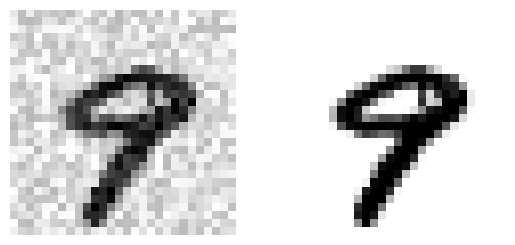

In [23]:
plt.subplot(121); plot_digit(X_test_mod[9])
plt.subplot(122); plot_digit(X_test[9])
plt.show()

In [20]:
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train_mod, y_train_mod)

KNeighborsClassifier()

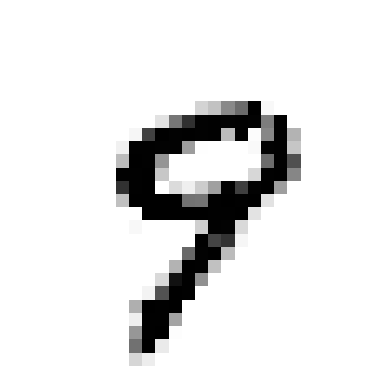

In [22]:
clean_digit = knn_clf.predict([X_test_mod[9]])
plot_digit(clean_digit)
plt.show()